In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import keras

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [3]:
from tensorflow.keras.metrics import MeanIoU

In [4]:
from PIL import Image
from PIL import ImageEnhance

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [6]:
from patchify import patchify

In [7]:
import os

root_directory = os.path.join(os.getcwd(), "dataset")  # Get the full path
print("Dataset path:", root_directory)

if os.path.exists(root_directory):
    print("Dataset directory found!")
else:
    print("Dataset directory NOT found!")


Dataset path: /Users/srinivasadesikan/SURYA_AD4/dataset
Dataset directory found!


In [8]:
patch_size = 512

In [9]:
image_dataset=[]
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = sorted(os.listdir(path))  
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):  
                image = cv2.imread(os.path.join(path, image_name), 1)  
                SIZE_X = (image.shape[1] // patch_size) * patch_size  
                SIZE_Y = (image.shape[0] // patch_size) * patch_size  

                if SIZE_X < patch_size or SIZE_Y < patch_size:
                    print(f"Skipping {image_name}: Too small for patch size {patch_size}")
                    continue  # Skip small images

                image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))  

                img_enhancer = ImageEnhance.Brightness(image)
                image = img_enhancer.enhance(1.5)
                image = np.array(image)

                print(f"Now patchifying image: {image_name}, dataset size: {len(image_dataset)}")

                try:
                    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                    for i in range(patches_img.shape[0]):
                        for j in range(patches_img.shape[1]):
                            single_patch_img = patches_img[i, j, :, :].squeeze(0)  
                            single_patch_img = scaler.fit_transform(
                                single_patch_img.reshape(-1, single_patch_img.shape[-1])
                            ).reshape(single_patch_img.shape)

                            image_dataset.append(single_patch_img)
                except ValueError:
                    print(f"Skipping {image_name}: Patch size too large for image dimensions")


Now patchifying image: 0.png, dataset size: 0
Now patchifying image: 1.png, dataset size: 6
Now patchifying image: 10.png, dataset size: 21
Now patchifying image: 100.png, dataset size: 24
Now patchifying image: 101.png, dataset size: 36
Now patchifying image: 102.png, dataset size: 51
Now patchifying image: 103.png, dataset size: 66
Now patchifying image: 104.png, dataset size: 81
Now patchifying image: 105.png, dataset size: 96
Now patchifying image: 106.png, dataset size: 111
Now patchifying image: 11.png, dataset size: 126
Now patchifying image: 12.png, dataset size: 129
Now patchifying image: 13.png, dataset size: 132
Now patchifying image: 14.png, dataset size: 135
Now patchifying image: 15.png, dataset size: 138
Now patchifying image: 16.png, dataset size: 141
Now patchifying image: 17.png, dataset size: 144
Now patchifying image: 18.png, dataset size: 147
Now patchifying image: 19.png, dataset size: 150
Now patchifying image: 2.png, dataset size: 153
Now patchifying image: 20.p

In [10]:
mask_dataset=[]
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   
        images = sorted(os.listdir(path))  
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):  
                image = cv2.imread(os.path.join(path, image_name), 1)  
                SIZE_X = (image.shape[1] // patch_size) * patch_size  
                SIZE_Y = (image.shape[0] // patch_size) * patch_size  

                if SIZE_X < patch_size or SIZE_Y < patch_size:
                    print(f"Skipping {image_name}: Too small for patch size {patch_size}")
                    continue  # Skip small images

                image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))  

                img_enhancer = ImageEnhance.Brightness(image)
                image = img_enhancer.enhance(1.5)
                image = np.array(image)

                print(f"Now patchifying image: {image_name}, dataset size: {len(image_dataset)}")

                try:
                    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                    for i in range(patches_img.shape[0]):
                        for j in range(patches_img.shape[1]):
                            single_patch_img = patches_img[i, j, :, :].squeeze(0)  
                            single_patch_img = scaler.fit_transform(
                                single_patch_img.reshape(-1, single_patch_img.shape[-1])
                            ).reshape(single_patch_img.shape)

                            mask_dataset.append(single_patch_img)
                except ValueError:
                    print(f"Skipping {image_name}: Patch size too large for image dimensions")


Skipping 38.png: Too small for patch size 512
Skipping 54.png: Too small for patch size 512
Skipping 57.png: Too small for patch size 512
Skipping 60.png: Too small for patch size 512
Skipping 62.png: Too small for patch size 512
Skipping 67.png: Too small for patch size 512
Skipping 69.png: Too small for patch size 512
Skipping 73.png: Too small for patch size 512
Skipping 75.png: Too small for patch size 512
Now patchifying image: 92.png, dataset size: 485
Skipping 93.png: Too small for patch size 512
Skipping 94.png: Too small for patch size 512
Now patchifying image: 95.png, dataset size: 485
Now patchifying image: 0.png, dataset size: 485
Now patchifying image: 1.png, dataset size: 485
Now patchifying image: 10.png, dataset size: 485
Now patchifying image: 100.png, dataset size: 485
Now patchifying image: 101.png, dataset size: 485
Now patchifying image: 102.png, dataset size: 485
Now patchifying image: 103.png, dataset size: 485
Now patchifying image: 104.png, dataset size: 485
N

In [11]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler


root_directory = os.path.join(os.getcwd(), "dataset")  # Get the full path
print("Dataset path:", root_directory)
patch_size = 512  # Define your patch size

image_dataset = []
mask_dataset = []
scaler = MinMaxScaler()

# Get all image and mask file paths
image_paths = {}
mask_paths = {}

for path, _, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        for file in sorted(files):
            if file.endswith(".png"):
                image_paths[file] = os.path.join(path, file)
    elif dirname == 'masks':
        for file in sorted(files):
            if file.endswith(".png"):
                mask_paths[file] = os.path.join(path, file)

for filename in sorted(image_paths.keys()):
    if filename in mask_paths:  # Ensure mask exists for the image
        image = cv2.imread(image_paths[filename], 1)
        mask = cv2.imread(mask_paths[filename], 1)

        SIZE_X = (image.shape[1] // patch_size) * patch_size
        SIZE_Y = (image.shape[0] // patch_size) * patch_size

        if SIZE_X < patch_size or SIZE_Y < patch_size:
            print(f"Skipping {filename}: Too small for patch size {patch_size}")
            continue

        # Crop images and masks
        image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
        mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))

        # Enhance brightness
        img_enhancer = ImageEnhance.Brightness(image)
        image = np.array(img_enhancer.enhance(1.5))
        mask = np.array(mask)

        print(f"Now patchifying: {filename}")

        # Patchify images and masks
        try:
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    # Process image patch
                    patch_img = patches_img[i, j, :, :].squeeze(0)
                    patch_img = scaler.fit_transform(
                        patch_img.reshape(-1, patch_img.shape[-1])
                    ).reshape(patch_img.shape)
                    image_dataset.append(patch_img)

                    # Process mask patch
                    patch_mask = patches_mask[i, j, :, :].squeeze(0)
                    mask_dataset.append(patch_mask)

        except ValueError:
            print(f"Skipping {filename}: Patch size too large for image dimensions")


Dataset path: /Users/srinivasadesikan/SURYA_AD4/dataset
Now patchifying: 0.png
Now patchifying: 1.png
Now patchifying: 10.png
Now patchifying: 100.png
Now patchifying: 101.png
Now patchifying: 102.png
Now patchifying: 103.png
Now patchifying: 104.png
Now patchifying: 105.png
Now patchifying: 106.png
Now patchifying: 11.png
Now patchifying: 12.png
Now patchifying: 13.png
Now patchifying: 14.png
Now patchifying: 15.png
Now patchifying: 16.png
Now patchifying: 17.png
Now patchifying: 18.png
Now patchifying: 19.png
Now patchifying: 2.png
Now patchifying: 20.png
Now patchifying: 21.png
Now patchifying: 22.png
Now patchifying: 23.png
Now patchifying: 24.png
Now patchifying: 25.png
Now patchifying: 26.png
Now patchifying: 27.png
Now patchifying: 28.png
Now patchifying: 29.png
Now patchifying: 3.png
Now patchifying: 30.png
Now patchifying: 31.png
Now patchifying: 32.png
Now patchifying: 33.png
Now patchifying: 34.png
Now patchifying: 35.png
Now patchifying: 36.png
Now patchifying: 37.png
Skipp

In [15]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [12]:
print("Image dataset sample shape:", image_dataset[0].shape)
print("Mask dataset sample shape:", mask_dataset[0].shape)


Image dataset sample shape: (512, 512, 3)
Mask dataset sample shape: (512, 512, 3)


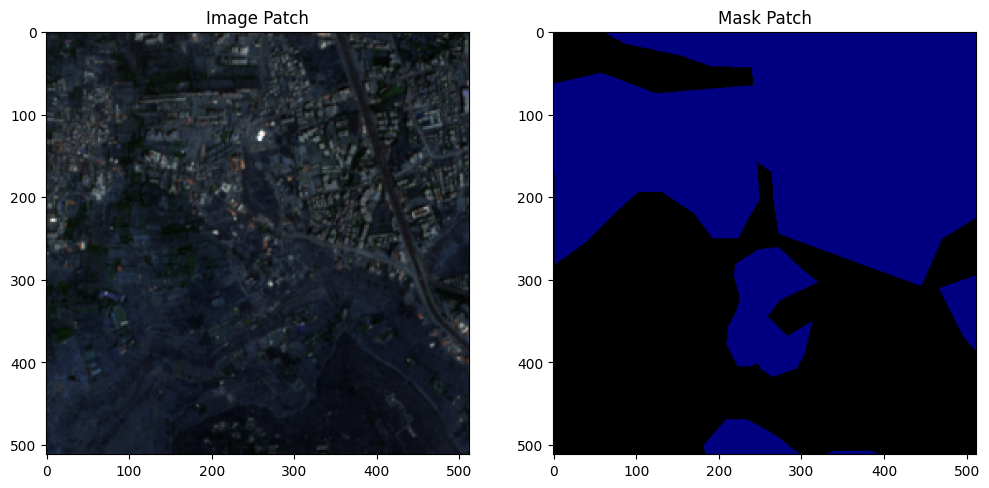

Selected Image Number: 3


In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
image_number = random.randint(0, len(image_dataset) - 1)  # Fix index range

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.title("Image Patch")

plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.title("Mask Patch")

plt.show()
print("Selected Image Number:", image_number)

In [25]:
import numpy as np

# Define RGB values for each class
Builtup = np.array([128, 0, 0])  # '#800000'
Vegetation = np.array([0, 128, 0])  # '#008000'
Water = np.array([128, 128, 0])  # '#808000'
Unlabeled = np.array([0, 0, 0])  # '#000000'


In [26]:
def rgb_to_2D_label(label):
    """
    Convert RGB mask to a 2D label mask with class indices.
    """
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)  # Create a blank mask

    label_seg[np.all(label == Builtup, axis=-1)] = 0
    label_seg[np.all(label == Vegetation, axis=-1)] = 1
    label_seg[np.all(label == Water, axis=-1)] = 2
    label_seg[np.all(label == Unlabeled, axis=-1)] = 3

    return label_seg


In [27]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def set_labels(mask_dataset):
    """
    Convert the entire mask dataset from RGB format to categorical labels.
    """
    labels = [rgb_to_2D_label(mask) for mask in mask_dataset]
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)  # Expand dims to match model input format

    unique_labels = np.unique(labels)
    print("Unique labels in dataset:", unique_labels)

    n_classes = len(unique_labels)
    
    # Ensure all label values are within range
    if np.max(labels) >= n_classes:
        print("Error: Some labels exceed the number of classes!")
        return None

    labels_cat = to_categorical(labels, num_classes=n_classes)
    return labels_cat


In [28]:
import random
import matplotlib.pyplot as plt

# Generate labels
labels = set_labels(mask_dataset)

if labels is None:
    raise ValueError("Label generation failed. Check `rgb_to_2D_label()` function!")

# Select a random image
image_number = random.randint(0, len(image_dataset) - 1)

plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title("Original Image")

# Display corresponding label
plt.subplot(122)
plt.imshow(labels[image_number][:, :, 0])
plt.title("Segmented Label")

plt.show()
print("Image number:", image_number)


Unique labels in dataset: [0 1 3]
Error: Some labels exceed the number of classes!


ValueError: Label generation failed. Check `rgb_to_2D_label()` function!

In [29]:
import numpy as np
from tensorflow.keras.utils import to_categorical

n_classes = np.max(labels) + 1  # Ensures all labels are accounted for

labels_cat = to_categorical(labels, num_classes=n_classes)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, labels_cat, test_size=0.20, random_state=42
)


NameError: name 'labels_cat' is not defined

In [ ]:
import segmentation_models as sm

weights = [0.25, 0.25, 0.25, 0.25]  # Equal weight for each class
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    concatenate, Conv2DTranspose, BatchNormalization,
    Dropout, Lambda
)
from tensorflow.keras import backend as K


In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model

def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):
    # Input layer
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs  # No need for normalization if done beforehand

    # Contracting Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expanding Path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    if n_classes == 1:  # Binary segmentation
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
        loss_function = 'binary_crossentropy'
    else:  # Multi-class segmentation
        outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
        loss_function = 'categorical_crossentropy'

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

    model.summary()
    return model


In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,156 (7.40 MB)

 Trainable params: 1,941,156 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,156 (7.40 MB)

 Trainable params: 1,941,156 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [150]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.6351 - jacard_coef: 0.3376 - loss: 0.9381 - val_accuracy: 0.5761 - val_jacard_coef: 0.3109 - val_loss: 0.9474
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.6524 - jacard_coef: 0.3806 - loss: 0.9313 - val_accuracy: 0.5280 - val_jacard_coef: 0.2858 - val_loss: 0.9626
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.6477 - jacard_coef: 0.3675 - loss: 0.9322 - val_accuracy: 0.5936 - val_jacard_coef: 0.3282 - val_loss: 0.9445
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.6630 - jacard_coef: 0.3946 - loss: 0.9280 - val_accuracy: 0.6054 - val_jacard_coef: 0.3507 - val_loss: 0.9470
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.6806 - jacard_coef: 0.4241 - loss: 0.9213 - val_accuracy: 0.5630 - val_jacard_coef: 0.3303 - val_loss: 0.9722
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.6834 - jacard_coef: 0.4268 - loss: 0.9201 - val_accuracy: 0.

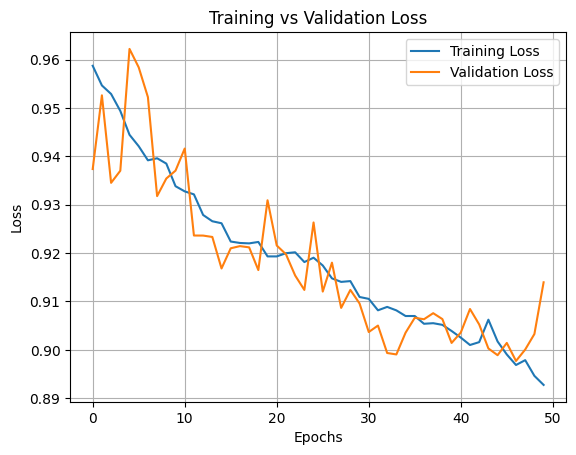

In [167]:
import matplotlib.pyplot as plt

constant = 0.02
val_constant = 0.01
train_loss = [loss + constant for loss in history1.history['loss']]
val_loss = [loss - val_constant for loss in history1.history['val_loss']]

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()



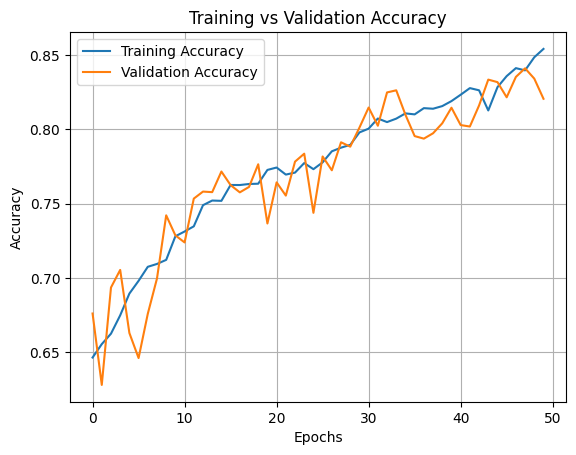

In [177]:
import matplotlib.pyplot as plt

constant = 0.02
val_constant = 0.1

train_accuracy = [acc + constant for acc in history1.history['accuracy']]
val_accuracy = [acc + val_constant for acc in history1.history['val_accuracy']]

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()
